# Comprehensive Guide to Using And Querying Neo4j Graph Databases in Python

## Introduction to Graph Databases and Neo4j

Data scientists start learning about SQL from the cradle. That's understandable given the ubiquity and high usefulness of tabular information. However, there are other successful database formats like graph databases to store connected data that don't fit into a relational SQL database. In this tutorial, we will learn about Neo4j, a popular graph database management system, to create, manage and query graph databases in Python. 

### What are graph databases?


Before we start talking all about Neo4j, let's take a moment to understand graph databases better. 

Graph databases are a type of NoSQL databases (don't use SQL) designed for managing connected data. Unlike traditional relational databases that use tables and rows, graph databases use graph structures that are made up of:
- __Nodes (entities)__ such as people, places, concepts
- __Edges (relationships)__ that connect different nodes like _person_ LIVES IN _a place_, or _a football player_ SCORED IN _a match_. 
- __Properties (attributes for nodes/edges)__ like the age of a person, or when in the match the goal was scored.

This structure makes graph databases ideal for handling interconnected data in fields and applications such as social networks, recommendations, fraud detection, etc. often outperforming relational DBs in terms of querying efficiency. Here is a structure of a sample graph database for a football dataset:

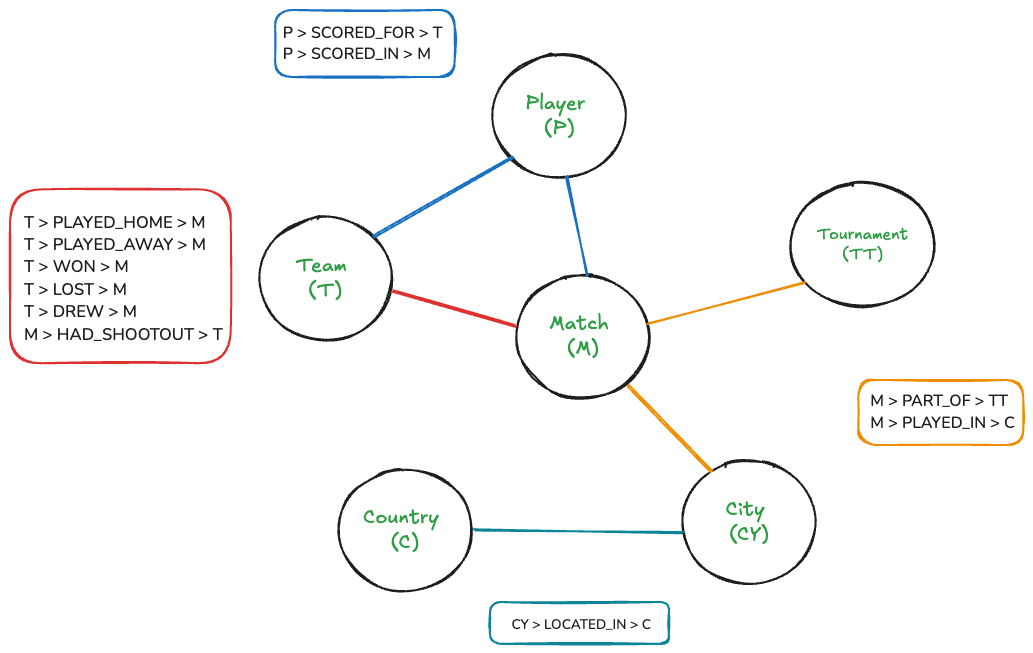

Even though this graph represents something fairly intuitive to humans, it can get pretty complicated if drawn on canvas. But with Neo4j, traversing this graph will be as straightforward as writing simple SQL joins. 

The graph has six nodes: Match, Team, Tournament, Player, Country and City. The rectangles list the relationships that exist between nodes. There are also a few node and relationship properties:
- Match: date, home_score, away_score
- Team: name
- Player: name
- Tournament: name
- City: name
- Country: name
- SCORED_FOR, SCORED_IN: minute, own_goal, penalty
- HAD_SHOOTOUT: winner, first_shooter


This schema allows us to represent:
- All matches with their scores, dates, and locations
- Teams participating in each match (home and away)
- Players scoring goals, including details like minute, own goals, and penalties
- Tournaments that matches are part of
- Cities and countries where matches are played
- Shootout information, including winners and first shooters (when available)

The schema captures the hierarchical nature of locations (City within Country) and the various relationships between entities (e.g., Teams playing Matches, Players scoring for Teams in Matches).

This structure allows for flexible querying, such as finding all matches between two teams, all goals scored by a player, or all matches in a specific tournament or location.

But let's not get ahead of ourselves. For starters, what is Neo4j and why use it?

### Why use Neo4j?


Neo4j, the leading name in the world of graph DB management, is known for its powerful features and versatility. 

At its core, Neo4j uses native graph storage, highly optimized to carry out graph operations. Its efficiency in handling complex relations makes it outperform traditional databases for connected data. Neo4j's scalability is truly impressive: it can handle billions of nodes and relationships with ease, making it suitable for both small projects and large enterprises. 

Another key aspect of Neo4j is data integrity. It ensures full ACID (Atomicity, Consistency, Isolation, Durability) compliance, providing reliability and consistency in transactions. 

Speaking of transactions, its query language, Cypher, offers a very intuitive and declarative syntax designed for graph patterns. For this reason, its syntax has been dubbed with the "ASCII art" nickname. Cypher will be no problem to learn, especially if you are familiar with SQL. 

With Cypher, it is easy to add new nodes, relationships or properties without worrying about breaking existing queries or schema. It is adaptable to rapidly changing requirements of modern development environments. 

Neo4j has a vibrant ecosystem support. It has extensive documentation, comprehensive tools to visualize graphs, active community and integrations with other programming languages such as Python, Java, and JavaScript.

## Setting Up Neo4j and a Python Environment


Before we dive into working with Neo4j, we need to set up our environment. This section will guide you through creating a cloud instance to host Neo4j databases, setting up a Python environment, and establishing a connection between the two.

### Not installing Neo4j

If you wish to work with local graph databases in Neo4j, then you would need to [download and install it locally](https://neo4j.com/docs/operations-manual/current/installation/) along with its dependencies like Java. But in majority of the cases, you will be interacting with an existing remote Neo4j database on some cloud environment. 

For this reason, we won't install Neo4j on our system. Instead, we will create a free database instance on [Aura](https://neo4j.com/product/auradb/), Neo4j's fully managed cloud service. Then, we will use the `neo4j` Python client library to connect to this database and populate it with data.

### Creating a Neo4j Aura DB instance
To host a free graph database on Aura DB, visit [its product page](https://neo4j.com/product/auradb/) and click on "Get Started for Free".

Once you register, you will be presented with the available plans and you should choose the free option. Immediately, you will be given a new instance with username and password to connect to it:

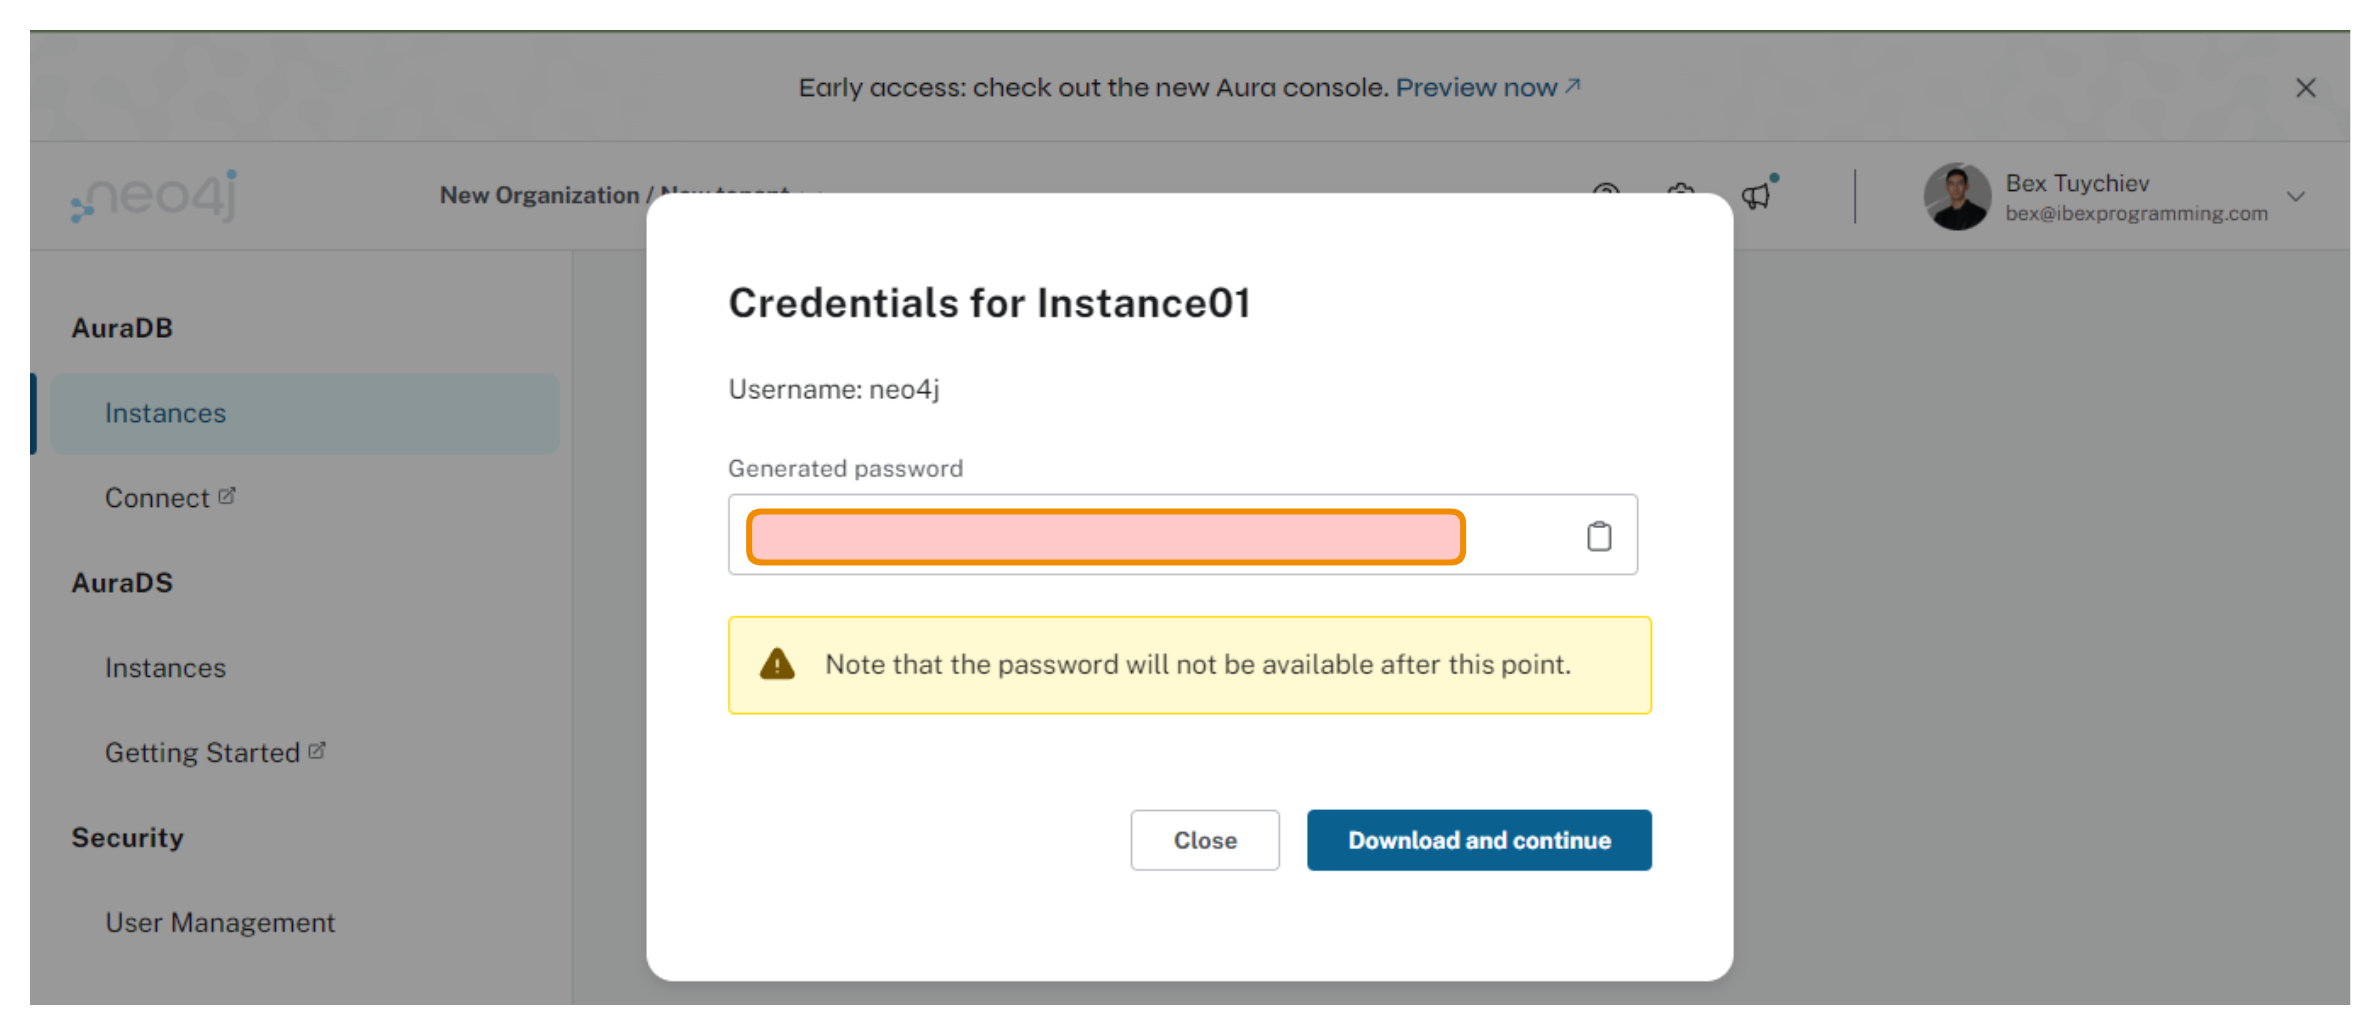

Copy your password, username and the connection URI.

Then, create a new working directory and a `.env` file to store your credentials:

```bash
$ mkdir neo4j_tutorial; cd neo4j_tutorial
$ touch .env
```

Paste the following contents inside the file:

```bash
NEO4J_USERNAME="YOUR-NEO4J-USERNAME"
NEO4J_PASSWORD="YOUR-COPIED-NEO4J-PASSWORD"
NEO4J_CONNECTION_URI="YOUR-COPIED-NEO4J-URI"
```

### Setting up the Python Environment

Now, we will install the `neo4j` Python client library in a new Conda environment:

```python
$ conda create -n neo4j_tutorial python=3.9 -y
$ conda activate neo4j_tutorial
$ pip install ipykernel  # To add the environment to Jupyter
$ ipython kernel install --user --name=neo4j_tutorial
$ pip install neo4j python-dotenv tqdm pandas
```

The commands also install `ipykernel` library and uses it to add the newly created Conda environment to Jupyter as a kernel. Then, we install `neo4j` Python client to interact with Neo4j databases and `python-dotenv` to manage our Neo4j credentials in a secure manner.

### Populating an AuraDB instance with football data

Data ingestion into a graph database is a complicated process that requires knowledge of Cypher fundamentals. Since we are yet to learn about Cypher basics, you will use a Python script that I have prepared for the article that will automatically ingest real-world historical football data. The script will use the credentials you have stored to connect to your AuraDB instance. 

The football data comes from [this Kaggle dataset on international football matches](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017/data) played between 1872 and 2024. The data is available in a CSV format, so the script breaks it down and converts it into graph format using Cypher and Neo4j. Towards the end of the article, when we are comfortable enough with these technologies, we will go through the script line-by-line so you can understand how to convert tabular information into a graph. 

Here are the commands to run (ensure you have set up the AuraDB instance and stored your credentials in a `.env` file in your working directory):

```bash
$ wget https://raw.githubusercontent.com/BexTuychiev/medium_stories/refs/heads/master/2024/9_september/3_neo4j_python/ingest_football_data.py
$ python ingest_football_data.py
```

The script may take a few minutes to run depending on your machine and Internet connection. But once it finishes, your AuraDB instance must show over 64k nodes and over 340k relationships. 

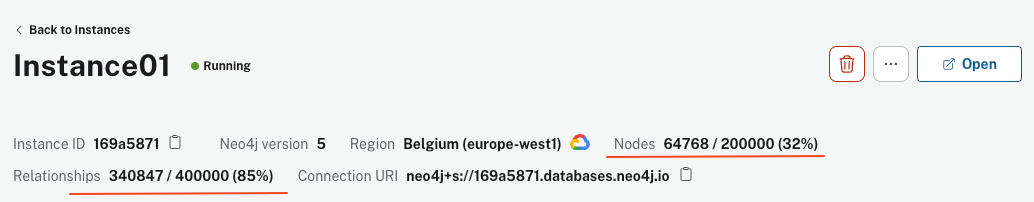

### Connecting to Neo4j From Python

Now, we are ready to connect to our Aura DB instance. First, we will read our credentials from the `.env` file using `dotenv`:

In [8]:
import os
from dotenv import load_dotenv

load_dotenv()

NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_URI = os.getenv("NEO4J_URI")

Now, let's establish a connection:

In [9]:
from neo4j import GraphDatabase

uri = NEO4J_URI
username = NEO4J_USERNAME
password = NEO4J_PASSWORD

driver = GraphDatabase.driver(uri, auth=(username, password))

try:
    driver.verify_connectivity()
    print("Connection successful!")
except Exception as e:
    print(f"Failed to connect to Neo4j: {e}")

Connection successful!


Here is an explanation of the code:

1. We import `GraphDatabase` from `neo4j` to interact with Neo4j.

2. We use the previously loaded environment variables to set up our connection (`uri`, `username`, `password`).

3. We create a driver object using `GraphDatabase.driver()`, establishing a connection to our Neo4j database.

4. Under a `with` block, we use the `verify_connectivity()` function to see if a connection is established. By default, `verify_connectivity()` returns nothing if a connection is successful. 

Once the tutorial finishes, call `driver.close()` to terminate the connection and free up resources. Driver objects are expensive to create, so you should only create a single object for your application.

## Cypher Query Language Essentials


Cypher's syntax is designed to be intuitive and visually representative of graph structures. It relies on the following ascii-art type of syntax:

```sql
(nodes)-[:CONNECT_TO]->(other_nodes)
```

Let's break down the key components of this general query pattern:

1. **Nodes**: 

In a Cypher query, a keyword in parentheses signifies a node name. For example, `(Player)` matches all Player nodes. Almost always, node names are referred to with aliases to make queries more readable, easier to write and compact. You can add an alias to a node name by putting a colon before it: `(m:Match)`. 

Inside the parentheses, you can specify one or more node properties for precise matching using dictionary-like syntax. For example:

```sql
// All tournament nodes that are FIFA World Cup
`(t:Tournament {name: "FIFA World Cup"})`
```

Node properties are written as-is while the value you want them to have must be a string. 

2. **Relationships**:

Relationships connect nodes to each other and they are wrapped with square brackets and arrows:

```sql
// Match nodes that are PART_OF some tournament
(m:Match)-[PART_OF]->(t:Tournament)
```

You can add aliases and properties to relationships as well:

```sql
// Matches that Brazil participated in a penalty shootout and was the first shooter
(p:Player) - [r:SCORED_FOR {minute: 90}] -> (t:Team)
```

Relationships are wrapped with arrows `-[RELATIONSHIP]->`. Again, you can include aliases properties inside braces. For example:

```sql
// All players who scored an own goal
(p:Player)-[r:SCORED_IN {own_goal: True}]->(m:Match)
``` 

3. **Clauses**:

Just like `COUNT(*) FROM table_name` would not return anything without a `SELECT` clause in SQL, `(node) - [RELATIONSHIP] -> (node)` wouldn't fetch any results. So, just like in SQL, Cypher has different clauses to structure your query logic like SQL:

- `MATCH`: Pattern matching in the graph
- `WHERE`: Filtering the results
- `RETURN`: Specifying what to include in the result set
- `CREATE`: Creating new nodes or relationships
- `MERGE`: Creating unique nodes or relationships
- `DELETE`: Removing nodes, relationships, or properties
- `SET`: Updating labels and properties

Here's a sample query that demonstrates these concepts:

```sql
MATCH (p:Player)-[s:SCORED_IN]->(m:Match)-[PART_OF]->(t:Tournament)
WHERE t.name = "FIFA World Cup" AND s.minute > 80 AND s.own_goal = True
RETURN p.name AS Player, m.date AS MatchDate, s.minute AS GoalMinute
ORDER BY s.minute DESC
LIMIT 5
```

This query finds all players who scored own goals in World Cup matches after the 80th minute mark. It reads almost like SQL but its SQL equivalent would involve at least one JOIN. 

## 4. Using Neo4j Python Driver to Analyze a Graph Database

## 5. Advanced Querying with Cypher


### Complex queries


### Pattern matching


### Aggregations and sorting



## 6. Working with Neo4j in Python


### Using the Neo4j Python driver


### Executing Cypher queries from Python


### Handling results



## 7. Visualizing Graph Data


### Tools for graph visualization


### Creating simple visualizations in Python



## 8. Best Practices and Optimization Tips


### Data modeling guidelines


### Query optimization


### Common pitfalls to avoid



## 9. Real-world Use Case: Building a Recommendation System


### Designing the graph model


### Implementing recommendation queries


### Integrating with a Python application



## 10. Conclusion and Next Steps


### Recap of key concepts


### Resources for further learning


### Emerging trends in graph databases